In [2]:
import sys
sys.path.append('..')

import dgl
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from KGCN import Model, loss_fn
from sklearn.metrics import roc_auc_score
from util import Group

Using backend: pytorch


In [3]:
def process_graph(graph: dgl.heterograph):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ground_truth = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    user_repo = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue

        edges = graph.edges(etype=etype)

        ground_truth[edges[0], edges[1]] = 1
        user_repo[edges[0], edges[1]] = 1
    
    repos_per_user = torch.sum(user_repo, axis=1)

    return ground_truth, repos_per_user.numpy()

In [4]:
def process_edge_data(graph, edge_data):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ratings = np.zeros((number_of_users, number_of_repos))
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        edges = graph.edges(etype=etype)
        data = torch.squeeze(edge_data[etype]).numpy()
        ratings[edges[0], edges[1]] = np.maximum(ratings[edges[0], edges[1]], data)
    
    return ratings

In [5]:
def compute_auc(graph, pos_score, neg_score):
    auc_scores = []
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        pos_data = torch.squeeze(pos_score[etype])
        neg_data = torch.squeeze(neg_score[etype])
        
        scores = torch.cat([pos_data, neg_data]).numpy()
        labels = torch.cat(
            [torch.ones(pos_data.shape[0]), torch.zeros(neg_data.shape[0])]).numpy()

        auc_score = roc_auc_score(labels, scores)

        auc_scores.append(auc_score)
    
    return np.mean(auc_scores)

In [6]:
g, l = dgl.load_graphs('../data/sub_kowledge_graph.bin')
train_graph = g[0]
valid_graph = g[1]
test_graph = g[2]
train_pos_g = g[3]
train_neg_g = g[4]
valid_pos_g = g[5]
valid_neg_g = g[6]
test_pos_g = g[7]
test_neg_g = g[8]

user_feat = train_graph.ndata['graph_data']['user']
repo_feat = train_graph.ndata['graph_data']['repo']

EPOCH = 100
TOP_K = 10
REPO_INPUT_SIZE = repo_feat.shape[1]
USER_INPUT_SIZE = user_feat.shape[1]
USER_REPO_OUTPUT_SIZE = 125
HIDDEN_OUTPUT_SIZE = 96
OUT_SIZE = 50

In [19]:
learning_rates = (0.001, 0.005, 0.01, 0.02, 0.05, 0.09, 0.1)

training_results = {}

for lr in learning_rates:
    model = Model(train_graph, USER_INPUT_SIZE, REPO_INPUT_SIZE, USER_REPO_OUTPUT_SIZE, HIDDEN_OUTPUT_SIZE, OUT_SIZE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    ground_truth_valid_data, repos_per_user_valid = process_graph(valid_graph)
    ground_truth_test_data, repos_per_user_test = process_graph(test_graph)

    training_loops = 0
    total_loss = 0
    total_valid_loss = 0
    valid_loss = 0

    for epoch in range(EPOCH):
        model.train()
        pos_score, neg_score = model(train_graph, train_pos_g, train_neg_g, user_feat, repo_feat)
        loss = loss_fn(pos_score, neg_score)

        total_loss += loss.item()
        training_loops += 1

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_avg_loss = total_loss / training_loops

        model.eval()
        with torch.no_grad():
            valid_user_feat = valid_graph.ndata['graph_data']['user']
            valid_repo_feat = valid_graph.ndata['graph_data']['repo']
            pos_score, neg_score = model(valid_graph, valid_pos_g, valid_neg_g, valid_user_feat, valid_repo_feat)
            valid_loss = loss_fn(pos_score, neg_score)
            total_valid_loss += valid_loss.item()
            valid_avg_loss = total_valid_loss / training_loops

        # conpute the AUC score
        auc_score = 0
        model.eval()
        with torch.no_grad():
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            pos_score = model.predict(test_pos_g, out)
            neg_score = model.predict(test_neg_g, out)

            auc_score = compute_auc(train_graph, pos_score, neg_score)

            epoch_results = [
                epoch, 
                train_avg_loss, 
                valid_avg_loss,
                auc_score
            ]

            if lr not in training_results:
                training_results[lr] = []
                
            training_results[lr].append(epoch_results)

In [20]:
data_columns = [
    'epoch', 
    'loss', 
    'valid loss',
    'auc'
]

data = []
for lr in learning_rates:
    data.append(pd.DataFrame(training_results[lr], columns=data_columns))

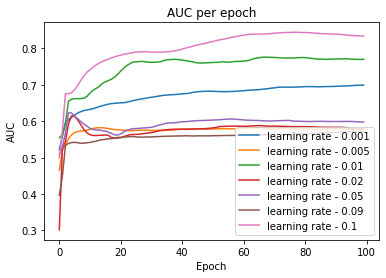

In [21]:
for i, d in enumerate(data):
    plt.plot(d['epoch'], d['auc'], label='learning rate - %s' % learning_rates[i])
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC per epoch')
plt.legend()